In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../data/GRAPE_QUALITY.csv")
df.shape

(1000, 13)

# Data Preparation and Cleaning

In [3]:
def check_nulls_and_types(df):
    nulls_df = (df.isnull().sum()/ df.shape[0]*100).round(2).to_frame().rename(columns={0:'percentage_nulls'})
    types_df = df.dtypes.to_frame().rename(columns={0:'data_type'})
    rv = nulls_df.merge(types_df, left_index=True, right_index=True)
    return rv

In [4]:
def prepare_data(df):
    df['quality_category'] = pd.Categorical(df['quality_category'])
    df['harvest_date'] = pd.to_datetime(df['harvest_date'])
    df['harvest_year'] = df['harvest_date'].dt.year
    df['harvest_month'] = df['harvest_date'].dt.month
    df['harvest_day'] = df['harvest_date'].dt.day
    df = df.drop(columns=['sample_id', 'harvest_date'], axis=1)
    return df

In [5]:
df = prepare_data(df)

In [6]:
check_nulls_and_types(df)

,percentage_nulls,data_type
variety,0.0,object
region,0.0,object
quality_score,0.0,float64
quality_category,0.0,category
sugar_content_brix,0.0,float64
acidity_ph,0.0,float64
cluster_weight_g,0.0,float64
berry_size_mm,0.0,float64
sun_exposure_hours,0.0,float64
soil_moisture_percent,0.0,float64


In [7]:
# All observations come from the same year will drop this variable later due to lack of variation.
df.harvest_year.value_counts()

harvest_year
2023    1000
Name: count, dtype: int64

# Train/Val/Test Split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.20, random_state=40)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=40)
print(len(df_train), len(df_val), len(df_test))
# Keep train copy for charts
df_train_c = df_train.copy()

600 200 200


In [9]:
target = "quality_category"

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

# Correlations with Numerical Vars

In [13]:
df_train_c['quality_category_codes'] = df_train_c['quality_category'].cat.codes

In [14]:
numerical_vars = df.select_dtypes(include='number').columns.to_list()+['quality_category_codes']

In [15]:
def correlation_w_target(df, numerical):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numerical].corr(), annot=True,  fmt='.2f')
    # Adding title and labels
    plt.title("Correlations", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.tight_layout() 
    plt.show()

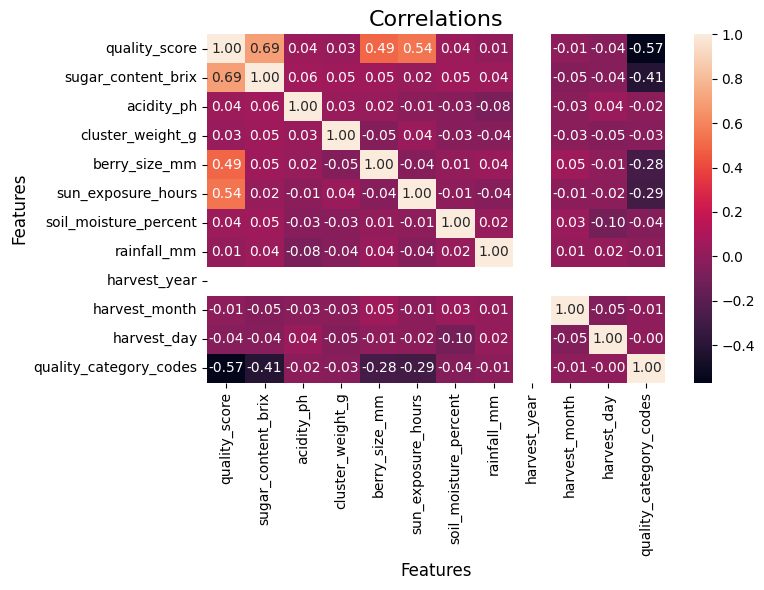

In [16]:
correlation_w_target(df_train_c, numerical_vars)

In [19]:
def identify_top_k_w_target(df, numerical, k):
    target = 'quality_category_codes'
    corr_matrix = df[numerical].corr()
    corr_matrix = corr_matrix[[target]].reset_index().rename(columns={"index":"features"})
    corr_matrix["abs_value"] = corr_matrix[target].abs()
    corr_matrix = corr_matrix.query("features!=@target")
    return corr_matrix.sort_values("abs_value", ascending=False).head(k).reset_index(drop=True)

In [20]:
top_k_numerical_features = identify_top_k_w_target(df_train_c, numerical_vars, 5)
top_k_numerical_features

,features,quality_category_codes,abs_value
0,quality_score,-0.568777,0.568777
1,sugar_content_brix,-0.413078,0.413078
2,sun_exposure_hours,-0.290892,0.290892
3,berry_size_mm,-0.281698,0.281698
4,soil_moisture_percent,-0.044551,0.044551


# Zoom-In: Top 5 Numerical Features

The correlation coefficients for the top 5 numerical features show:

- A strong correlation between our target `quality_category` and:

    - quality score
    - sugar content
    - sun exposure
    - berry size in mm

The boxplots below show how these features have a very different distribution across quality categories.

For example, Premium quality seem to have a higher quality score and sugar content and the distribution of Premium quality appears to have a small variance across features compared Medium and High quality.

From this correlation analysis, we also learned that there is no variation in `harvest_year`, so we can drop this feature when we move to the modeling stage.

In [21]:
plot_lst = list(zip(top_k_numerical_features['features'][:-1], [[0, 0], [0, 1], [1, 0], [1, 1]]))

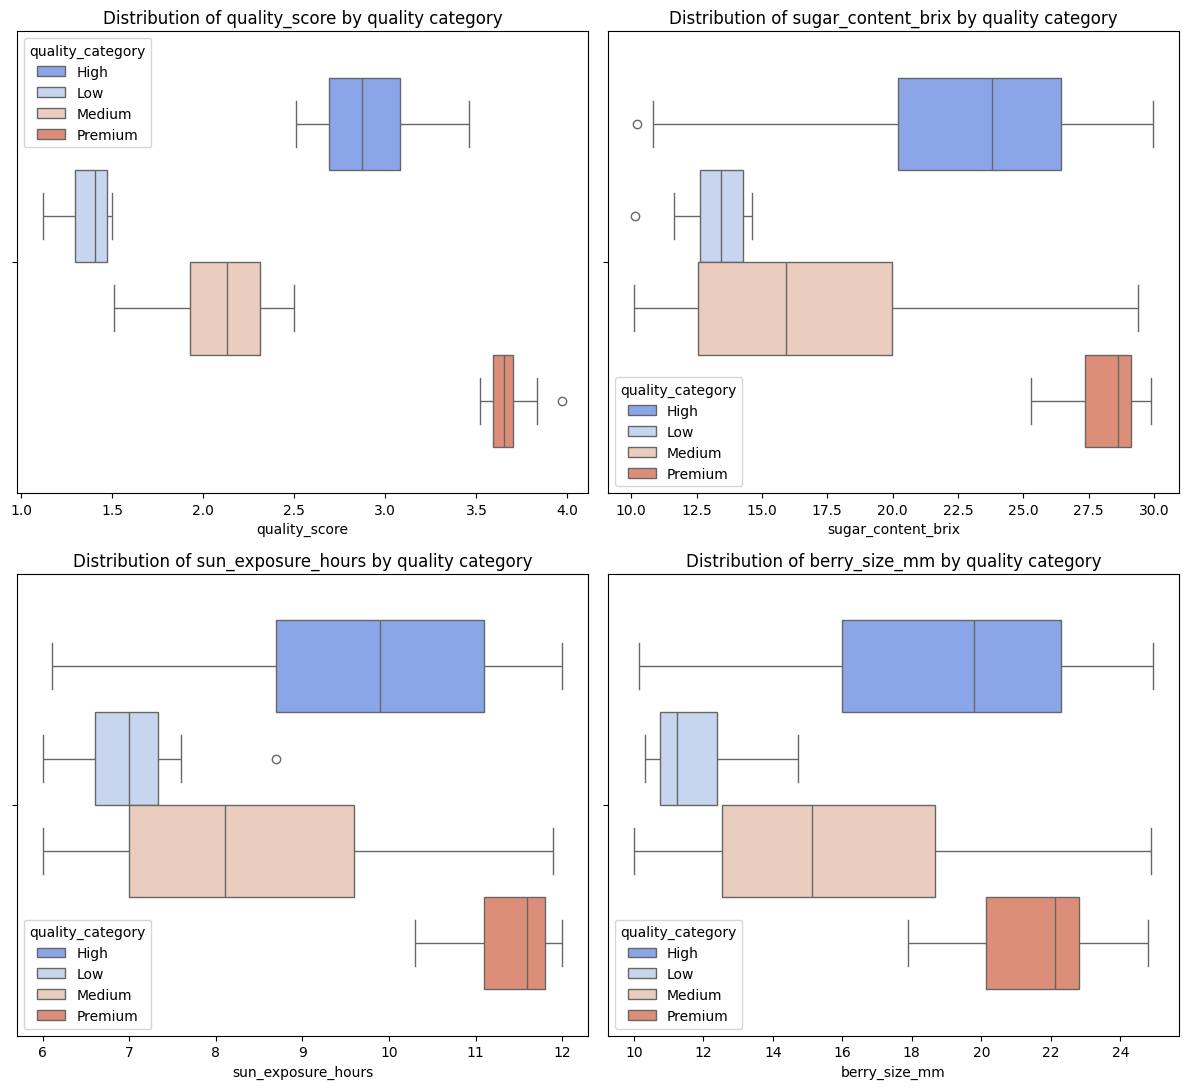

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
palette = sns.color_palette("Set2")
for col, loc in plot_lst:
    sns.boxplot(data=df_train_c, x=col, hue="quality_category", palette='coolwarm', ax=axes[loc[0], loc[1]])
    axes[loc[0], loc[1]].set_title(f"Distribution of {col} by quality category")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Categorical Features

In [63]:
categorical_vars = df.select_dtypes(include='object').columns.to_list()
categorical_vars

['variety', 'region']

In [66]:
for c in categorical_vars:
    mscore = mutual_info_score(df_train_c[c], df_train_c['quality_category_codes']).round(3)
    print(f"Mutual Infortion Score for {c}: {mscore}")

Mutual Infortion Score for variety: 0.019
Mutual Infortion Score for region: 0.026


In [50]:
def plot_crosstab(df, target, feature):
    crosstab = pd.crosstab(df[target], df[feature])
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap="YlGnBu", cbar=True)
    plt.title("Relationship Between Target and Variety")
    plt.xlabel("Quality Category")
    plt.ylabel(f"{feature.capitalize()}")
    plt.show()

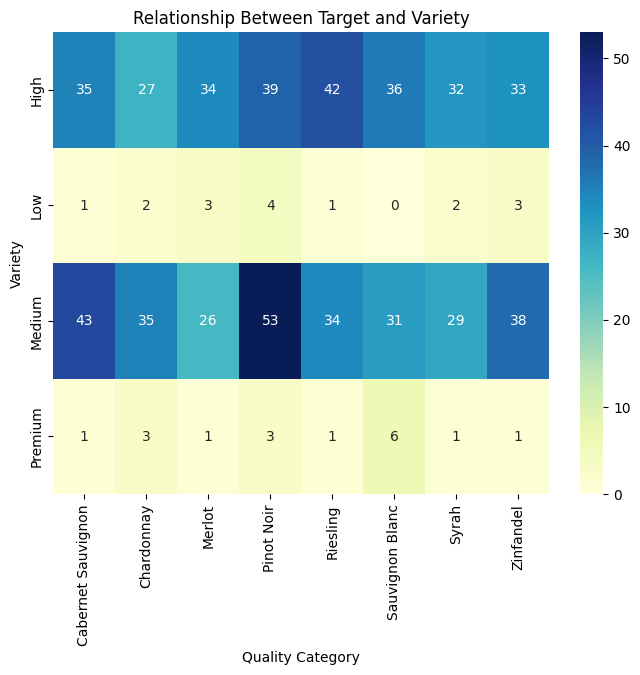

In [51]:
plot_crosstab(df_train_c, target='quality_category', feature='variety')

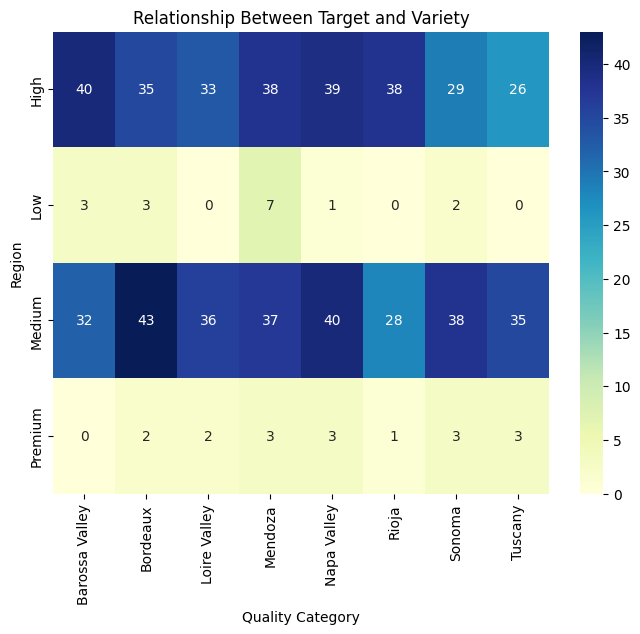

In [52]:
plot_crosstab(df_train_c, target='quality_category', feature='region')

# What we learned from categorical features:

- It seems that the variety is roughly uniformly distributed for High and Medium quality. For Premium quality, the highest count is Sauvignon Blanc and Low quality has it highest counts in Pinot Noir and Merlot.

- With regards to region, Premium, High and Medium seem to have a uniform dsitribution across regions, while Low quality has the highest counts in Mendoza.

- This suggests that some of these features may be helpful to distinguish Premium and Low quality, but will not necessarily provide a lot of information for Medium and High.

Model Selection

- I will use accuracy as a metric to compare different models

- The baseline model will be DecisionTreeClassifier where we will tune max_depth and min_samples_leaf.

- The challenger model will be RandomForestClassifier, where we will tune three of its main hyperparameters: n_estimators, max_depth and min_samples_leaf.

In [77]:
del df_train['harvest_year']
del df_val['harvest_year']
del df_test['harvest_year']

In [78]:
def transform_data(df):
    dicts = df.to_dict(orient='records')
    dv = DictVectorizer(sparse=True)
    X = dv.fit_transform(dicts)
    return X, dv

In [100]:
def transform_predict(df, dv):
    dicts = df.to_dict(orient='records')
    return dv.transform(dicts)

In [79]:
X_train, dv = transform_data(df_train)

In [80]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [104]:
X_val = transform_predict(df_val, dv)
X_test = transform_predict(df_test, dv)

In [105]:
y_pred_val = dt.predict(X_val)
accuracy_score(y_val, y_pred_val)

1.0

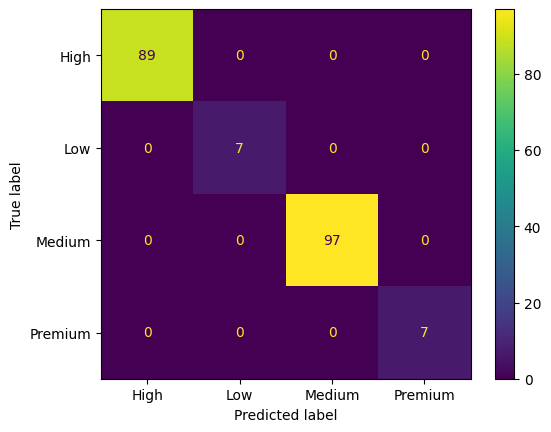

In [108]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)
plt.show()